In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import shuffle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn

df=pd.read_csv("/content/drive/MyDrive/CSE499/AllData.csv")
df.head(200)


,Time,Acc_x,Acc_y,Acc_z,Gry_x,Gry_y,Gry_Z,Person,Class
0,1.560000e+12,0.499756,0.798584,-0.313110,-16.768293,-10.091463,11.189024,4,Eating
1,1.560000e+12,0.497314,0.826172,-0.312622,-6.981707,-11.310976,10.731707,4,Eating
2,1.560000e+12,0.495605,0.825562,-0.313477,-5.823171,-11.402439,3.993902,4,Eating
3,1.560000e+12,0.493408,0.823242,-0.314697,-5.091463,-11.067073,6.890244,4,Eating
4,1.560000e+12,0.495605,0.819336,-0.315552,-4.115854,-11.189024,16.890244,4,Eating
...,...,...,...,...,...,...,...,...,...
195,1.560000e+12,-0.415161,0.886719,-0.390259,-4.024390,-3.384146,22.408537,4,Eating
196,1.560000e+12,-0.360596,0.836304,-0.378174,-18.506098,4.451220,3.993902,4,Eating
197,1.560000e+12,-0.408447,0.833862,-0.339233,-17.713415,6.463415,-1.463415,4,Eating
198,1.560000e+12,-0.367920,0.877563,-0.336914,-8.780488,1.615854,8.628049,4,Eating


In [3]:
df=df.drop('Person',axis=1)
df=df.drop('Time',axis=1)

In [4]:
df


,Acc_x,Acc_y,Acc_z,Gry_x,Gry_y,Gry_Z,Class
0,0.499756,0.798584,-0.313110,-16.768293,-10.091463,11.189024,Eating
1,0.497314,0.826172,-0.312622,-6.981707,-11.310976,10.731707,Eating
2,0.495605,0.825562,-0.313477,-5.823171,-11.402439,3.993902,Eating
3,0.493408,0.823242,-0.314697,-5.091463,-11.067073,6.890244,Eating
4,0.495605,0.819336,-0.315552,-4.115854,-11.189024,16.890244,Eating
...,...,...,...,...,...,...,...
72089,-0.945923,-0.182861,0.105103,-70.457317,-11.829268,11.463415,Walking
72090,-0.898315,-0.176880,0.078857,-71.280488,-11.890244,10.884146,Walking
72091,-0.863159,-0.199097,0.086548,-71.676829,-19.390244,-1.006098,Walking
72092,-0.904907,-0.189941,0.088989,-58.963415,-10.152439,25.731707,Walking


In [5]:
df.shape

(72094, 7)

In [6]:
df['Class'].value_counts()


Speak and Walk    18673
Staying           16453
Walking           14541
Speaking          12867
Eating             9560
Name: Class, dtype: int64

In [7]:
df.isnull().sum() #find missing data

Acc_x    0
Acc_y    0
Acc_z    0
Gry_x    0
Gry_y    0
Gry_Z    0
Class    0
dtype: int64

In [8]:
# Variables-
epochs = 50
batch_size = 64
num_classes = 6
fig_size = (9,7)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# split data into training and testing sets
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.10, random_state=42)


In [10]:
# FUNCTIONS-

def PREPROCESS(X , y):
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    y = np.array(y)
    return X,y

def CREATE_MODEL(input_shape):
    model = Sequential()
    model.add(Input(shape = input_shape,))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(num_classes,activation='softmax'))
    return model

def COMPILE(model):
    model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )
    return model;

def FIT(model,X,y,i):
    history = model.fit(
    X,
    y,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(f'./model_{i}.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=1
        )
    ],
    verbose=0
    )
    return history,model

def PLOT(history,i):
    epochs_range = range(epochs)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_loss,label="Training Loss")
    plt.plot(epochs_range,val_loss,label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Model {i} - Loss Over Time")
    plt.show()

    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_acc,label="Training accuracy")
    plt.plot(epochs_range,val_acc,label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title(f"Model {i} - Accuracy")
    plt.show()

def CONFUSION_MATRIX(y_test, y_pred):
    confusionMatrix = confusion_matrix(y_test, y_pred)
    sns.set(font_scale=1.5)
    labels = ["Eating", "Speak and Walk", "Speaking", "Staying", "Walking"]
    plt.figure(figsize=(16,7))
    sns.heatmap(confusionMatrix, cmap = "Blues", annot = True, fmt = ".0f", xticklabels=labels, yticklabels=labels)
    plt.title("Global Model Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 45)
    plt.show()

def LOAD_MODELS():
    for i in range(1,4):
        model = load_model(f'./model_{i}.h5')
        all_models.append(model)

def APPLY_WEIGHT_FUNCTION(weights):
    avg_model_weights = []
    n_models = len(all_models)
    n_layers = len(all_models[0].get_weights())
    for layer in range(n_layers):
        layer_weights = np.array([model.get_weights()[layer] for model in all_models])
        avg_layer_weights = np.average(layer_weights, axis=0, weights=weights)
        avg_model_weights.append(avg_layer_weights)
    return avg_model_weights;

# **Model replica number-1**

In [35]:
# MODEL REPLICA NO.1
X_train_1 = X_train[0:15000]
y_train_1 = y_train[0:15000]
X_train_1, y_train_1 = PREPROCESS(X_train_1,y_train_1);
model_1 = CREATE_MODEL(X_train_1.shape[1]);
model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 256)               1792      
                                                                 
 dropout_24 (Dropout)        (None, 256)               0         
                                                                 
 dense_41 (Dense)            (None, 128)               32896     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_42 (Dense)            (None, 64)                8256      
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_43 (Dense)            (None, 32)               

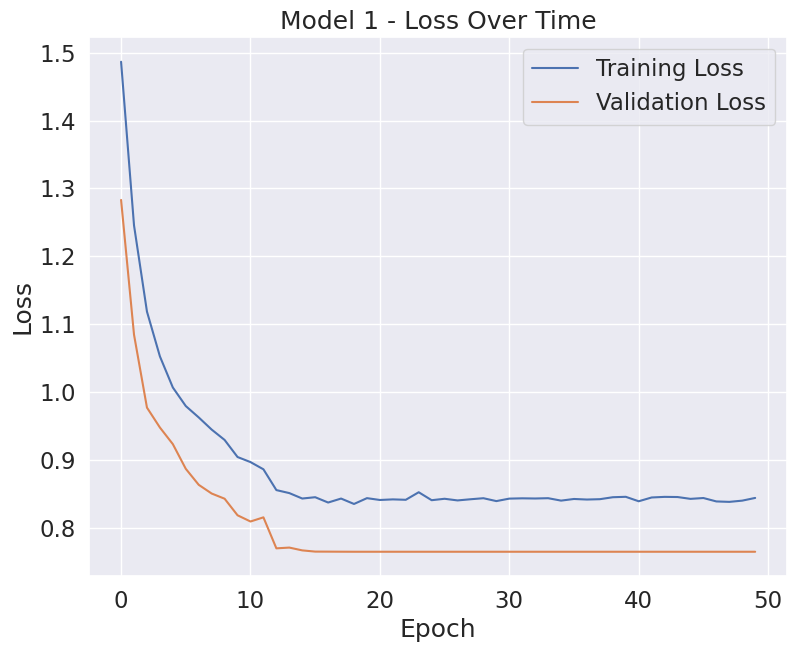

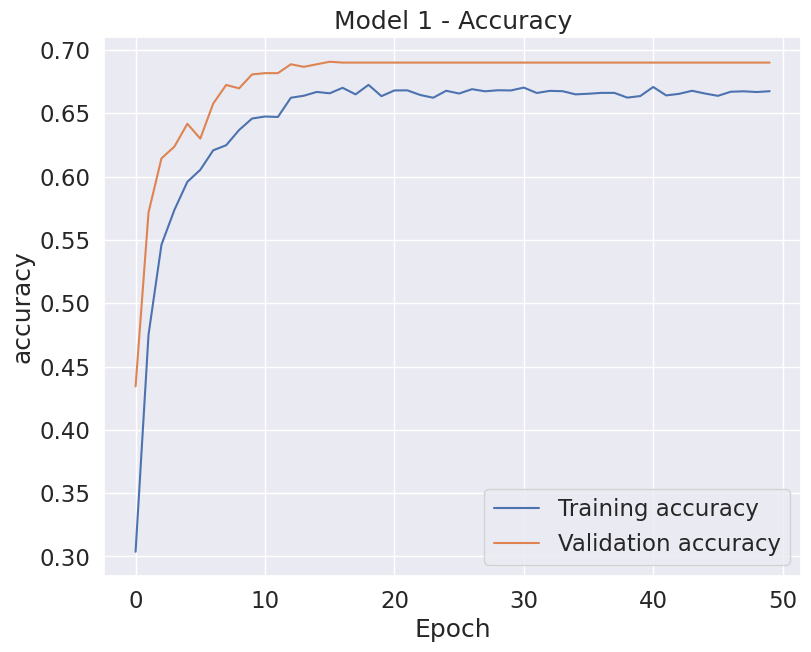

In [24]:
from sklearn.preprocessing import LabelEncoder

# Assuming your y_train_1 contains string labels
label_encoder = LabelEncoder()
y_train_1 = label_encoder.fit_transform(y_train_1)

model_1 = COMPILE(model_1)
history_1,model_1 = FIT(model_1,X_train_1,y_train_1,1)
PLOT(history_1,1)

# **Model replica number-2**

In [36]:
# MODEL REPLICA NO.2
X_train_2 = X_train[15000:30000]
y_train_2 = y_train[15000:30000]
X_train_2, y_train_2 = PREPROCESS(X_train_2,y_train_2)
model_2 = CREATE_MODEL(X_train_2.shape[1])
model_2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 256)               1792      
                                                                 
 dropout_27 (Dropout)        (None, 256)               0         
                                                                 
 dense_46 (Dense)            (None, 128)               32896     
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_47 (Dense)            (None, 64)                8256      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_48 (Dense)            (None, 32)               

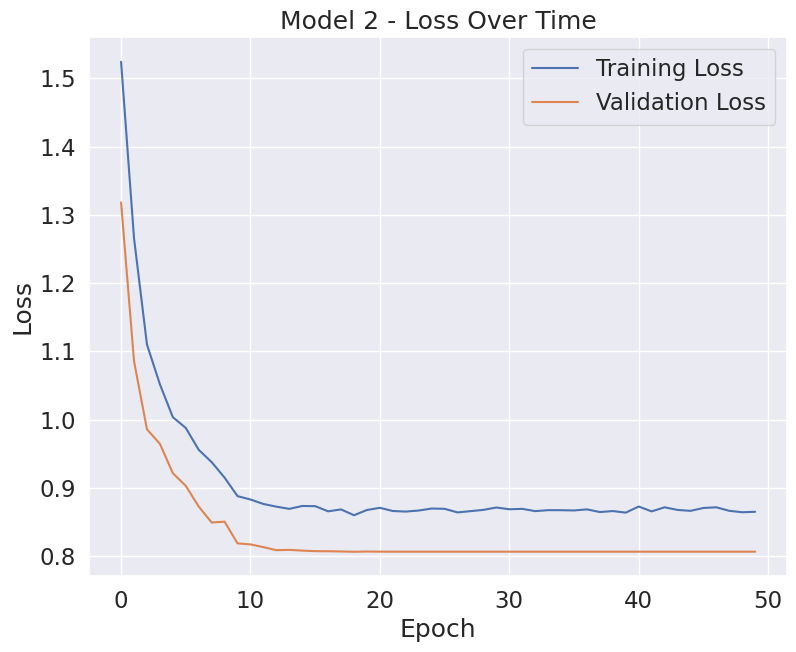

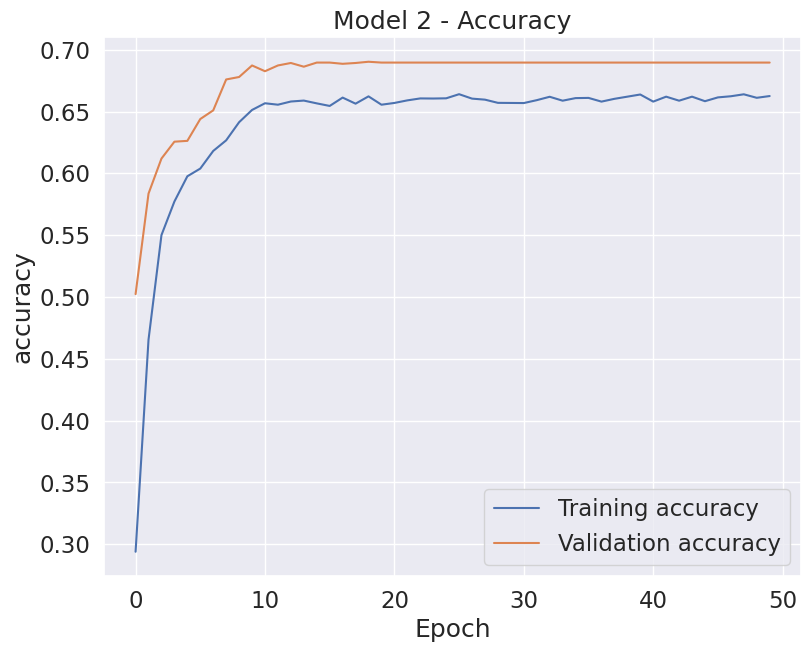

In [26]:
from sklearn.preprocessing import LabelEncoder

# Assuming your y_train_1 contains string labels
label_encoder = LabelEncoder()
y_train_2 = label_encoder.fit_transform(y_train_2)

model_2 = COMPILE(model_2)
history_2,model_2 = FIT(model_2,X_train_2,y_train_2,2);
PLOT(history_2,2);

# **Model replica number-3**

In [37]:
# MODEL REPLICA NO.3
X_train_3 = X_train[30000:45000]
y_train_3 = y_train[30000:45000]
X_train_3, y_train_3 = PREPROCESS(X_train_3,y_train_3)
model_3 = CREATE_MODEL(X_train_3.shape[1])
model_3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 256)               1792      
                                                                 
 dropout_30 (Dropout)        (None, 256)               0         
                                                                 
 dense_51 (Dense)            (None, 128)               32896     
                                                                 
 dropout_31 (Dropout)        (None, 128)               0         
                                                                 
 dense_52 (Dense)            (None, 64)                8256      
                                                                 
 dropout_32 (Dropout)        (None, 64)                0         
                                                                 
 dense_53 (Dense)            (None, 32)              

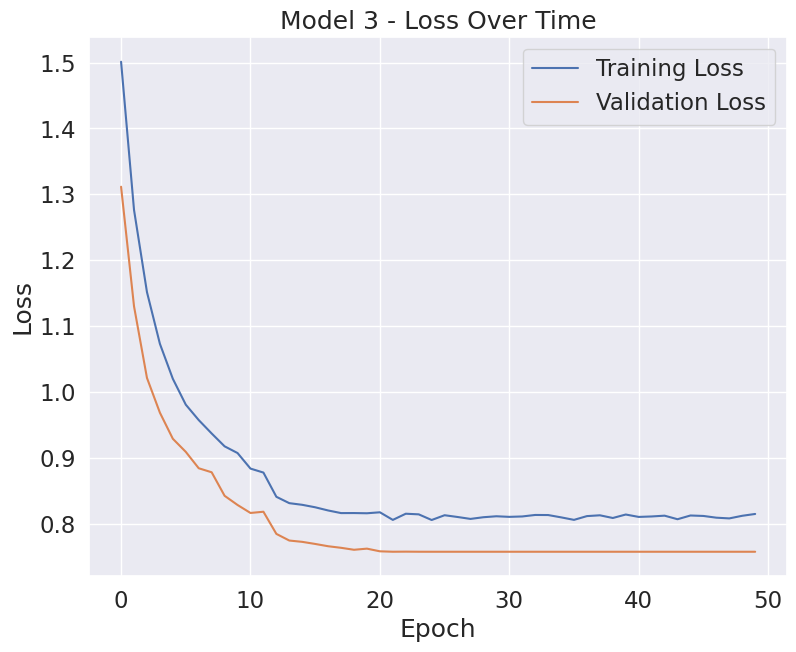

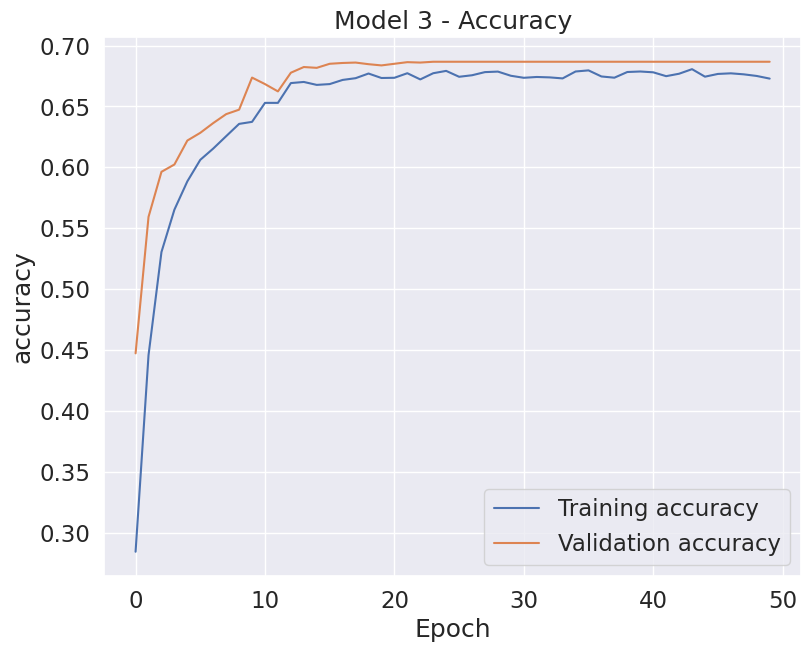

In [28]:
from sklearn.preprocessing import LabelEncoder

# Assuming your y_train_1 contains string labels
label_encoder = LabelEncoder()
y_train_3 = label_encoder.fit_transform(y_train_3)

model_3 = COMPILE(model_3);
history_3, model_3 = FIT(model_3,X_train_3,y_train_3,3)
PLOT(history_3,3)

# **The Global Model**

In [38]:
num_samples = X_train.shape[0]

# Print the number of samples in X_test
print(f"Number of samples in X_test: {num_samples}")

Number of samples in X_test: 64884


In [39]:
X_test, y_test = PREPROCESS(X_test, y_test)

In [40]:
model_g = CREATE_MODEL(X_test.shape[1])
model_g.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 256)               1792      
                                                                 
 dropout_33 (Dropout)        (None, 256)               0         
                                                                 
 dense_56 (Dense)            (None, 128)               32896     
                                                                 
 dropout_34 (Dropout)        (None, 128)               0         
                                                                 
 dense_57 (Dense)            (None, 64)                8256      
                                                                 
 dropout_35 (Dropout)        (None, 64)                0         
                                                                 
 dense_58 (Dense)            (None, 32)              

In [41]:
all_models = []
LOAD_MODELS()
weights = [max(history_1.history['accuracy']), max(history_2.history['accuracy']), max(history_3.history['accuracy'])]
x = max(weights)
idx = weights.index(x)
weights[idx] = 1
x = min(weights)
idx = weights.index(x)
weights[idx] = 0.02
for i in range(3):
    if(weights[i] != 1 and weights[i] != 0.02):
        weights[i] = 0.03
        break
avg_model_weights = APPLY_WEIGHT_FUNCTION(weights)

In [42]:
from sklearn.preprocessing import LabelEncoder

# Assuming your y_train_1 contains string labels
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)

model_g.set_weights(avg_model_weights)
model_g = COMPILE(model_g)
_ , accuracy = model_g.evaluate(X_test,y_test,verbose=0)
print(f"Global Model Accuracy: {round(accuracy*100,2)}%")

Global Model Accuracy: 49.9%


226/226 [==============================] - 1s 2ms/step


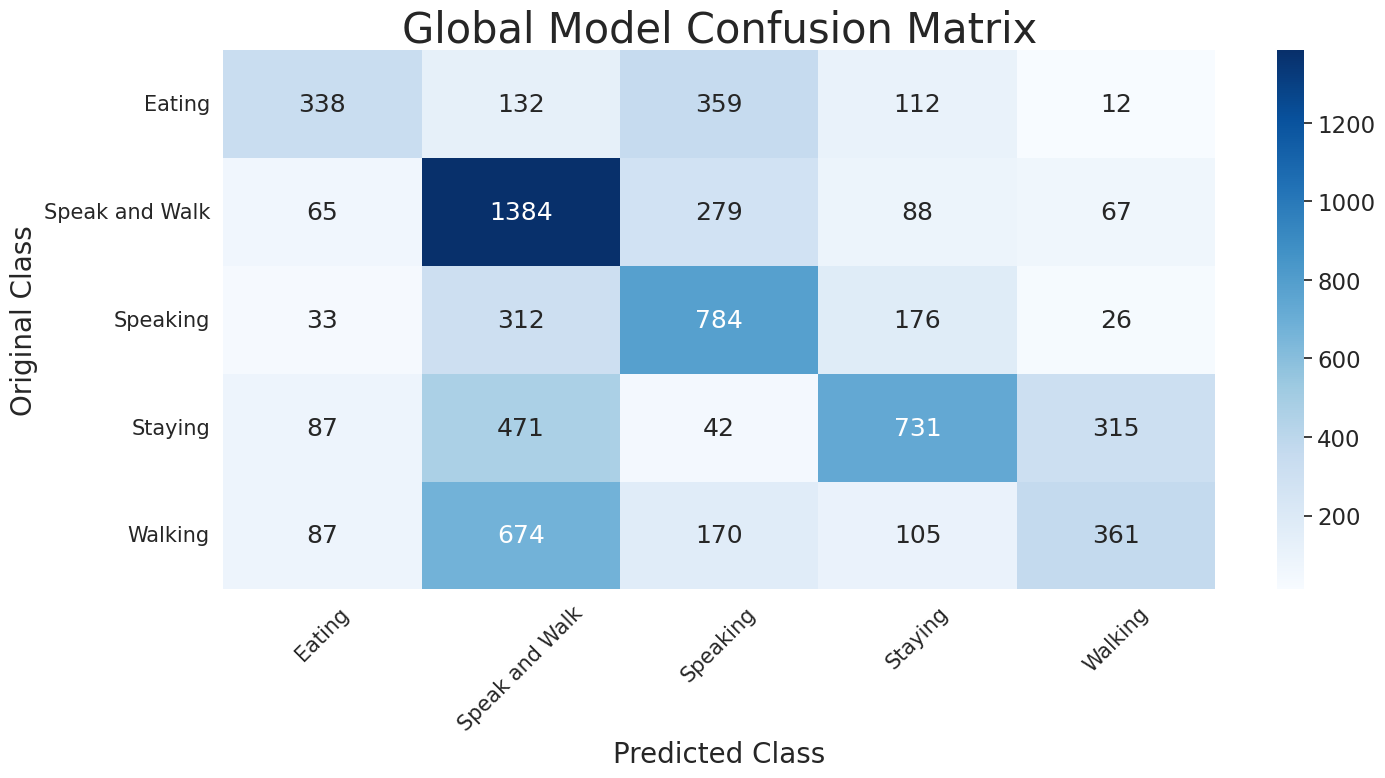

In [43]:
y_pred = model_g.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
CONFUSION_MATRIX(y_test,y_pred)